<a href="https://colab.research.google.com/github/mindyng/Projects/blob/master/Short_Term_Household_Energy_Consumption_Predictions_with_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective: Predict Household Energy Consumption using Prophet

## :: Supervised Multivariate Prob with 1 hr time steps (Original data in min time steps)

Inspired by: 


*   https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet
*   https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial



## Load libraries.

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fbprophet
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import sys 
from scipy.stats import randint
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

In [88]:
df = pd.read_csv("/content/drive/My Drive/household_power_consumption.csv",index_col=[0], parse_dates=[0])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


Target variable will be Global_active_power and predictors will be remaining variables.



## EDA to explore some of the variables.

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   sub_metering_4         float64
dtypes: float64(8)
memory usage: 142.5 MB


In [90]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,9.314693e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.585916e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


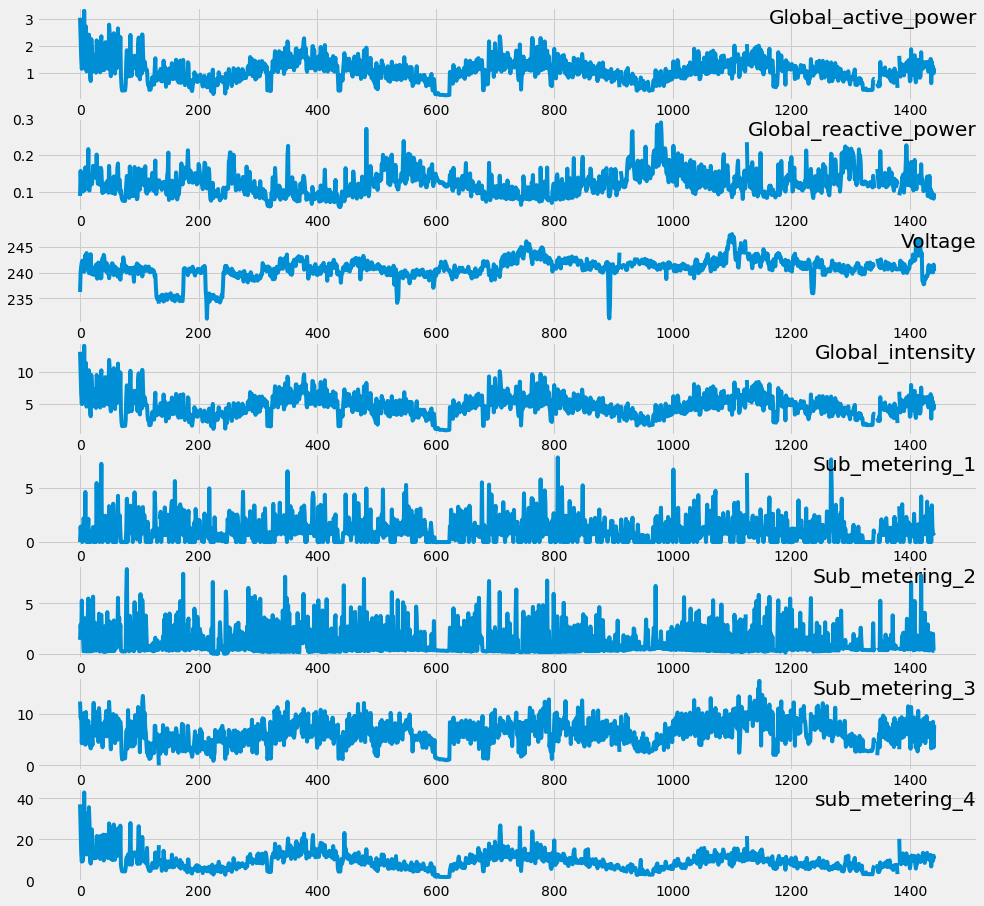

In [91]:
# Below I compare the means of different features resampled over day. 

cols = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 15))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

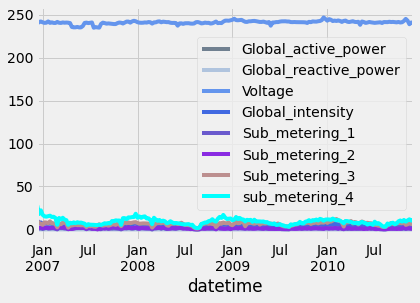

In [92]:
## Different features' means resampled over week.

df.Global_active_power.resample('W').mean().plot(color='slategrey', legend=True)
df.Global_reactive_power.resample('W').mean().plot(color='lightsteelblue', legend=True)
df.Voltage.resample('W').mean().plot(color='cornflowerblue', legend=True)
df.Global_intensity.resample('W').mean().plot(color='royalblue', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='slateblue', legend=True)
df.Sub_metering_2.resample('W').mean().plot(color='blueviolet', legend=True)
df.Sub_metering_3.resample('W').mean().plot(color='rosybrown', legend=True)
df.sub_metering_4.resample('W').mean().plot(color='cyan', legend=True)
plt.show()

As we can see, Voltage units are way above the other variables. There will be normalization before fitting training and test set to Prophet object. 

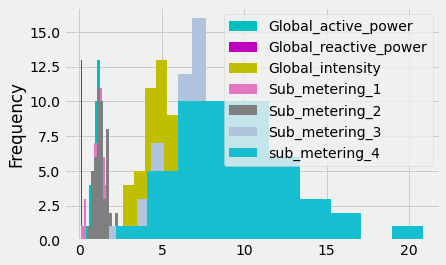

In [93]:
# Different features' mean resampled over month.
df.Global_active_power.resample('M').mean().plot(kind='hist', color='c', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='m', legend=True)
#df.Voltage.resample('M').mean().plot(kind='hist',color='y', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='y', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='tab:pink', legend=True)
df.Sub_metering_2.resample('M').mean().plot(kind='hist', color='tab:gray', legend=True)
df.Sub_metering_3.resample('M').mean().plot(kind='hist', color='lightsteelblue', legend=True)
df.sub_metering_4.resample('M').mean().plot(kind='hist', color='tab:cyan', legend=True)
plt.show()

Voltage taken out of graph because its values are much higher than rest of variables as seen in prior graph. So it pushed the rest of variables to the left. So in order to view other variables more clearly Voltage not included. 

Based on this visualization, we can see that Global_active_power is highest in variance and values amongst remaining plotted variables.

Moving on to Correlation, which help us see how closely associated variables are to one another.

## Correlation

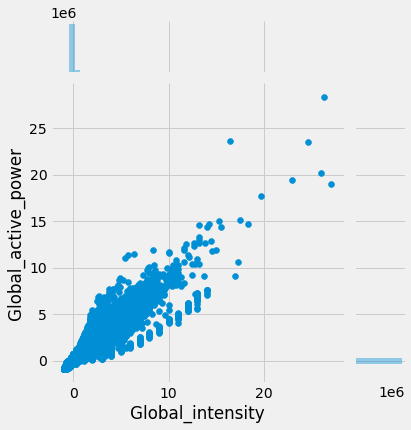

In [94]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

There is a strong almost 1:1 relationship (pearsonr = 0.94) between Global active power and Global intensity.

Now let us take a look at the relationship between Global active power and Voltage.

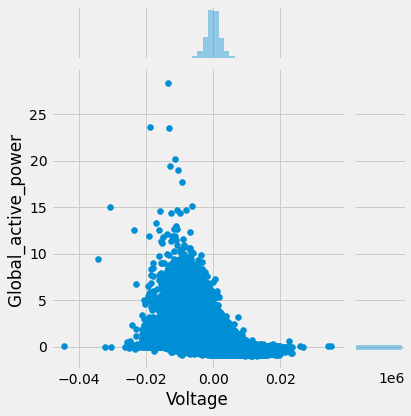

In [95]:
## The correlations between 'Voltage' and 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  

plt.show()

We can see here that the relationship is not as strong, specifically it is (pearsonr = -0.3).

Now let us look at some heatmaps with changing aggregations over time.

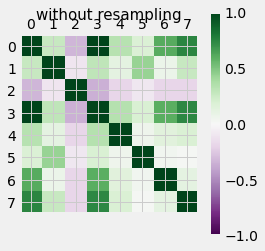

In [96]:
# Correlations among columns without resampling (raw data)
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

There is the expected strong relationship along the diagonal and between variables 0 and 3.

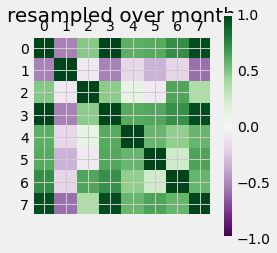

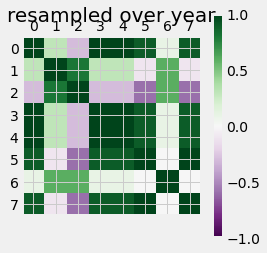

In [97]:
# Correlations of features' means resampled over months and year.

plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=20)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=20)
plt.colorbar()
plt.show()

We can see once there are different aggregations over time, new strong correlations between variables pop up. 

# Data Prep for Prophet

1. To reduce computation time, aggregating min data to hr format.
2. Drop NaN's/replace with mean value of column.
3. Make sure all values are float.
4. Normalize/scale features.
5. Split into Train and Test Set.

In [98]:
df_resample = df.resample('h').mean() 
df_resample.shape 

(34589, 8)

In [99]:
df_resample.isnull().sum()

Global_active_power      421
Global_reactive_power    421
Voltage                  421
Global_intensity         421
Sub_metering_1           421
Sub_metering_2           421
Sub_metering_3           421
sub_metering_4           421
dtype: int64

In [100]:
df_resample = df_resample.fillna(df_resample.mean())

In [101]:
df_resample.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

In [102]:
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
 7   sub_metering_4         34589 non-null  float64
dtypes: float64(8)
memory usage: 2.4 MB


In [103]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_resample = pd.DataFrame(scaled, index = df_resample.index, columns=df_resample.columns)
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:00:00,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.813346
2006-12-16 18:00:00,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560591
2006-12-16 19:00:00,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.585814
2006-12-16 20:00:00,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.572244
2006-12-16 21:00:00,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143


Overall view of target value (Global active power) in ordered time sequence.

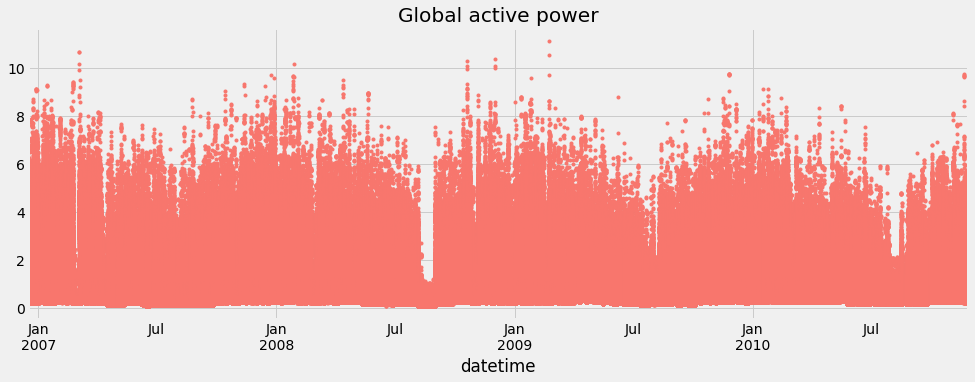

In [104]:
gap = df["Global_active_power"]

color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
gap.plot(style='.', figsize=(15,5), color=color_pal[0], title='Global active power')
plt.show()

Here, we are reminded of the overall trend of our target variable before it was normalized. We can see that there are some gaps a little after July. Some other seasonalities could be detected if new features are produced with time series index (future work).

In [105]:
# Train/Test Split

.8*34589

27671.2

In [106]:
n = 80
train = df_resample.head(int(len(df_resample)*(n/100)))
train

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:00:00,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.813346
2006-12-16 18:00:00,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.560591
2006-12-16 19:00:00,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.585814
2006-12-16 20:00:00,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.572244
2006-12-16 21:00:00,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.503143
...,...,...,...,...,...,...,...,...
2010-02-11 11:00:00,0.192697,0.075979,0.620683,0.181851,0.0,0.000000,0.863882,0.043213
2010-02-11 12:00:00,0.229694,0.099742,0.701288,0.215328,0.0,0.000000,0.878577,0.100767
2010-02-11 13:00:00,0.116144,0.064873,0.782079,0.108560,0.0,0.000000,0.382831,0.077164


Split date will be **2010-02-11**.

In [107]:
DF = df_resample.reset_index() \
    .rename(columns={'datetime':'ds',
                     'Global_active_power':'y'})

In [108]:
DF_train = DF.loc[DF["ds"]<="2010-02-11"]
DF_test  = DF.loc[DF["ds"]>"2010-02-11"]

In [109]:
model = Prophet()
model.add_regressor('Global_reactive_power')
model.add_regressor('Voltage')
model.add_regressor('Global_intensity')
model.add_regressor('Sub_metering_1')
model.add_regressor('Sub_metering_2')
model.add_regressor('Sub_metering_3')
model.add_regressor('sub_metering_4')

model.fit(DF_train)

In [110]:
forecast = model.predict(DF_test.drop(columns="y"))

In [111]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Global_intensity,Global_intensity_lower,Global_intensity_upper,Global_reactive_power,Global_reactive_power_lower,Global_reactive_power_upper,Sub_metering_1,Sub_metering_1_lower,Sub_metering_1_upper,Sub_metering_2,Sub_metering_2_lower,Sub_metering_2_upper,Sub_metering_3,Sub_metering_3_lower,Sub_metering_3_upper,Voltage,Voltage_lower,Voltage_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,sub_metering_4,sub_metering_4_lower,sub_metering_4_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-11 01:00:00,0.153794,0.027355,0.027577,0.153794,0.153794,0.000003,0.000003,0.000003,-4.307594e-07,-4.307594e-07,-4.307594e-07,-0.010841,-0.010841,-0.010841,-0.012634,-0.012634,-0.012634,-0.053000,-0.053000,-0.053000,0.000003,0.000003,0.000003,-0.126331,-0.126331,-0.126331,-5.573292e-07,-5.573292e-07,-5.573292e-07,-0.126291,-0.126291,-0.126291,-0.049820,-0.049820,-0.049820,-2.744722e-08,-2.744722e-08,-2.744722e-08,-0.000039,-0.000039,-0.000039,0.0,0.0,0.0,0.027463
1,2010-02-11 02:00:00,0.153794,0.028278,0.028509,0.153794,0.153794,0.000003,0.000003,0.000003,-3.723145e-07,-3.723145e-07,-3.723145e-07,-0.010841,-0.010841,-0.010841,-0.012634,-0.012634,-0.012634,-0.053000,-0.053000,-0.053000,0.000003,0.000003,0.000003,-0.125402,-0.125402,-0.125402,-3.911047e-07,-3.911047e-07,-3.911047e-07,-0.125363,-0.125363,-0.125363,-0.048893,-0.048893,-0.048893,1.078579e-08,1.078579e-08,1.078579e-08,-0.000038,-0.000038,-0.000038,0.0,0.0,0.0,0.028392
2,2010-02-11 03:00:00,0.153794,0.036888,0.037099,0.153794,0.153794,0.000003,0.000003,0.000003,-7.956947e-09,-7.956947e-09,-7.956947e-09,-0.010841,-0.010841,-0.010841,-0.003778,-0.003778,-0.003778,-0.053000,-0.053000,-0.053000,0.000004,0.000004,0.000004,-0.116799,-0.116799,-0.116799,-3.888176e-07,-3.888176e-07,-3.888176e-07,-0.116761,-0.116761,-0.116761,-0.049147,-0.049147,-0.049147,4.888585e-08,4.888585e-08,4.888585e-08,-0.000038,-0.000038,-0.000038,0.0,0.0,0.0,0.036996
3,2010-02-11 04:00:00,0.153794,0.079061,0.079289,0.153794,0.153794,0.000002,0.000002,0.000002,-2.297870e-07,-2.297870e-07,-2.297870e-07,-0.010841,-0.010841,-0.010841,-0.007973,-0.007973,-0.007973,-0.004836,-0.004836,-0.004836,0.000004,0.000004,0.000004,-0.074627,-0.074627,-0.074627,-4.594506e-07,-4.594506e-07,-4.594506e-07,-0.074590,-0.074590,-0.074590,-0.050944,-0.050944,-0.050944,8.658937e-08,8.658937e-08,8.658937e-08,-0.000037,-0.000037,-0.000037,0.0,0.0,0.0,0.079167
4,2010-02-11 05:00:00,0.153794,0.083573,0.083795,0.153794,0.153794,0.000002,0.000002,0.000002,-4.012110e-07,-4.012110e-07,-4.012110e-07,-0.010841,-0.010841,-0.010841,-0.012634,-0.012634,-0.012634,0.003709,0.003709,0.003709,0.000004,0.000004,0.000004,-0.070111,-0.070111,-0.070111,-4.300374e-07,-4.300374e-07,-4.300374e-07,-0.070074,-0.070074,-0.070074,-0.050312,-0.050312,-0.050312,1.236365e-07,1.236365e-07,1.236365e-07,-0.000036,-0.000036,-0.000036,0.0,0.0,0.0,0.083684


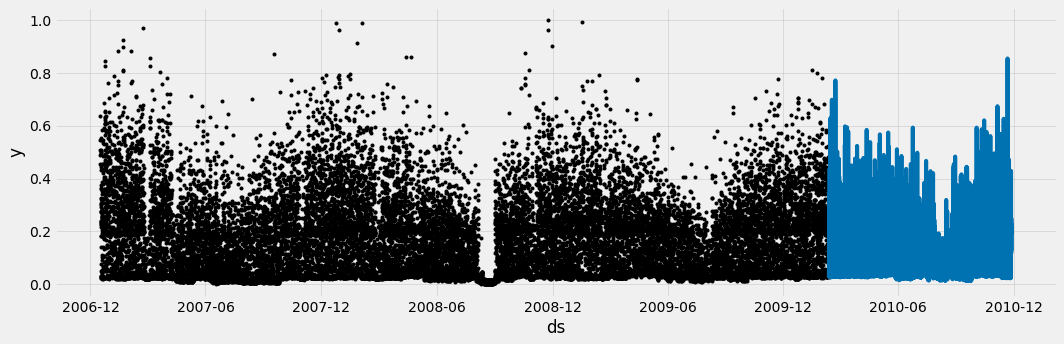

In [112]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,
                 ax=ax)
plt.show()

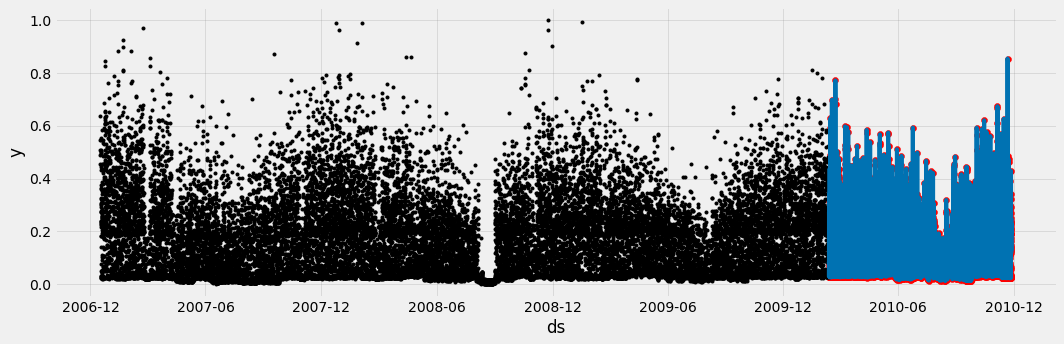

In [116]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(DF_test.ds, DF_test['y'], color='r')
fig = model.plot(forecast, ax=ax)

Not bad...predictions almost overlap actual (barely any offset). This means errors are not huge. Yay!

## Error Metrics 
### These allow us to assess how good the model is.

### RMSE

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [133]:
np.sqrt(mean_squared_error(DF_test['y'],forecast['yhat']))

0.00033575009297460827

### MAE

In [130]:

mean_absolute_error(DF_test['y'], forecast['yhat'])

0.00030316884407785403

### MAPE

In [135]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(DF_test['y'],
                   forecast['yhat'])

0.44092393446469835

Comparing Prophet's RMSE (0.00033575009297460827) to LSTM Time-Series model using similar data, but with one less sub_metering column (Test RMSE: 0.618), Prophet did better. This is unexpected since LSTM's usually do better than non DL models. Data prep for Prophet involved one more regresser than LSTM and LSTM was not optimially built (vanilla form). Therefore, this might explian Prophet's success. =)